# IPSENSE internship project

This project was made by **Matheus Bellucio**. contact me on this email: matheusbellucio@gmail.com

<hr>



In [107]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [108]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from typing import Callable

import requests
import json

<hr>

## Project Gutenberg Analysis

Project Gutenberg is an online library of free eBooks.

On this analysis we are going to look for some interesting data revolving around this free innitiative, those being:
- Books per author
- Top 10 genres
- Top 10 most downloaded books
- Relation between author Birth Year and Downloads/Popularity
- Most popular Authors

<hr>

### API endpoints

In [109]:
HEADERS = {
  'Content-Type': 'application/json',
  'Accept': 'application/json'
}

In [110]:
BOOKS = 'https://gutendex.com/books/'

In [111]:
NUM_PAGES = 156

### API Calls

In [112]:
def fetchJson(url: str, headers: dict) -> dict[str, any]:
  try: 
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()
  except requests.exceptions.RequestException as err: 
    raise err

Function created to make the API call and return the JSON with the data

### Dataframe creation and Data formatting 

In [113]:
def get_data(fetch_data: Callable, url: str, headers: dict, num_pages: int) -> pd.DataFrame:

  data = []
  first_page = fetch_data(url=url, headers=headers)
  data.extend(first_page['results'])
  page_link = first_page['next']

  for i in range(1, num_pages):
    page = fetch_data(url=page_link, headers=headers)
    data.extend(page['results'])
    page_link = page['next']

  return pd.DataFrame(data)

As the Gutendex API is paginated, this function aims to do the desired amount of calls base on the number of pages specified <br>
and return the dataframe with the data of all pages fetched.

Due to the API being paginated, the wait time is too long. Therefore I will base this analysis on a 5000 books frame.

To avoid waiting 8 minutes to all the data being fetched, simply comment the first line bellow and uncomment the second one.

In [114]:
df_books = get_data(fetch_data=fetchJson, url=BOOKS, headers=HEADERS, num_pages=NUM_PAGES)
# df_books = pd.read_json('./data.json')

In [115]:
df_books.to_json('./data.json')

### Exploring the data

First, checking the colums to see how big is the dataframe we are handling

In [116]:
df_books.columns

Index(['id', 'title', 'authors', 'translators', 'subjects', 'bookshelves',
       'languages', 'copyright', 'media_type', 'formats', 'download_count',
       'author_birth_year', 'first_author'],
      dtype='object')

Then we check the shape, to see how many rows we are working with, and a sample from the head.

In [117]:
print(df_books.shape)
df_books.head()

(4992, 13)


,id,title,authors,translators,subjects,bookshelves,languages,copyright,media_type,formats,download_count,author_birth_year,first_author
0,1513,Romeo and Juliet,"[{'name': 'Shakespeare, William', 'birth_year'...",[],"[Conflict of generations -- Drama, Juliet (Fic...","[Browsing: Fiction, Browsing: Literature, Brow...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,79350,1564.0,"Shakespeare, William"
1,2701,"Moby Dick; Or, The Whale","[{'name': 'Melville, Herman', 'birth_year': 18...",[],"[Adventure stories, Ahab, Captain (Fictitious ...","[Best Books Ever Listings, Browsing: Fiction, ...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,72591,1819.0,"Melville, Herman"
2,1342,Pride and Prejudice,"[{'name': 'Austen, Jane', 'birth_year': 1775, ...",[],"[Courtship -- Fiction, Domestic fiction, Engla...","[Best Books Ever Listings, Browsing: Culture/C...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,58898,1775.0,"Austen, Jane"
3,37106,"Little Women; Or, Meg, Jo, Beth, and Amy","[{'name': 'Alcott, Louisa May', 'birth_year': ...",[],"[Autobiographical fiction, Bildungsromans, Dom...",[],[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,53439,1832.0,"Alcott, Louisa May"
4,145,Middlemarch,"[{'name': 'Eliot, George', 'birth_year': 1819,...",[],"[Bildungsromans, City and town life -- Fiction...","[Best Books Ever Listings, Browsing: Culture/C...",[en],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,53226,1819.0,"Eliot, George"


Then we proceed with the info method, to check the data types of the colums. More specific, if the download_count is an integer, <br>
to prepare it for future math operations. In this case is already an integer.

In [118]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4992 entries, 0 to 4991
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4992 non-null   int64  
 1   title              4992 non-null   object 
 2   authors            4992 non-null   object 
 3   translators        4992 non-null   object 
 4   subjects           4992 non-null   object 
 5   bookshelves        4992 non-null   object 
 6   languages          4992 non-null   object 
 7   copyright          4992 non-null   bool   
 8   media_type         4992 non-null   object 
 9   formats            4992 non-null   object 
 10  download_count     4992 non-null   int64  
 11  author_birth_year  3943 non-null   float64
 12  first_author       4992 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 640.9+ KB


<hr>

# General statistics

### Books per Author

As the authors in the dataframe can be an array of authors, the function bellow checks that and return the name, or the first author name.

In [119]:
def get_author_name(authors):
    if isinstance(authors, dict) and 'name' in authors:
        return authors['name']
    elif isinstance(authors, list) and len(authors) > 0:
        return authors[0].get('name', '')
    return ''


In [120]:
books_per_author = df_books['authors'].apply(get_author_name).value_counts()
print('Books per author: ')
books_per_author.head(10)[2:]

Books per author: 


Dickens, Charles                 49
Shakespeare, William             46
Twain, Mark                      43
Anonymous                        40
Conrad, Joseph                   29
Plato                            28
Wells, H. G. (Herbert George)    27
Nietzsche, Friedrich Wilhelm     26
Name: authors, dtype: int64

As we can see, Charles Dickens is the author with the most books in this Data Analysis, followed by Shakespeare.

### Top 10 Genres

First, lets normalize the genre names, making all upper case and removing any special characters.

In [121]:
def remove_special_characters(s):
    return ''.join(char for char in s if char.isalnum() or char.isspace())

In [122]:
def subjects_to_upper(subject):
    if isinstance(subject, list) and len(subject) > 0:
        return list(map(lambda x: remove_special_characters(x.upper()), subject))
    return None

In [123]:
popular_subjects = df_books['subjects'].apply(lambda x: subjects_to_upper(x)).explode().value_counts()
print("\nMost Popular Subjects:")
print(popular_subjects.head(10))


Most Popular Subjects:
SHORT STORIES            151
SCIENCE FICTION          139
LOVE STORIES             108
HISTORICAL FICTION       106
ADVENTURE STORIES        102
ENGLAND  FICTION         100
PSYCHOLOGICAL FICTION     98
DOMESTIC FICTION          89
FAIRY TALES               77
BILDUNGSROMANS            75
Name: subjects, dtype: int64


In Project Gutenberg, apparently the book genre that has the most books is Short Stories, followed up by Science Fiction.<br>
The real surprise here is the genre 'Bildungsromans' being in the 10th position.

### Top 10 most downloaded books

In [124]:
most_downloaded_books = df_books.sort_values('download_count', ascending=False).head(10)

top_downloads_bar = px.bar(
  x=most_downloaded_books.title, 
  y=most_downloaded_books.download_count, 
  title='Top 10 most downloaded books',
  height=700
)
top_downloads_bar.show()

We can conclude that the classic books are indeed the most downloaded, with a romance novel being in the 1st position, <br> 
although the romance genre being the 3rd most common genre.

# Relation between author Birth Year and Downloads/Popularity

If multiple authors, a validation must be done to get the birth year either from a string or a list.

In [125]:
def get_author_birth_year(authors):
    if isinstance(authors, list) and len(authors) > 0:
        return authors[0].get('birth_year', None)
    return None

In [126]:
df_books['author_birth_year'] = df_books['authors'].apply(get_author_birth_year)

In [127]:
birth_vs_downloads = df_books.groupby('author_birth_year').agg({'download_count': pd.Series.sum}).sort_values('download_count', ascending=False).reset_index()
birth_vs_downloads.head(5)

,author_birth_year,download_count
0,1564.0,179380
1,1819.0,158505
2,1832.0,133674
3,1721.0,122876
4,1874.0,110544


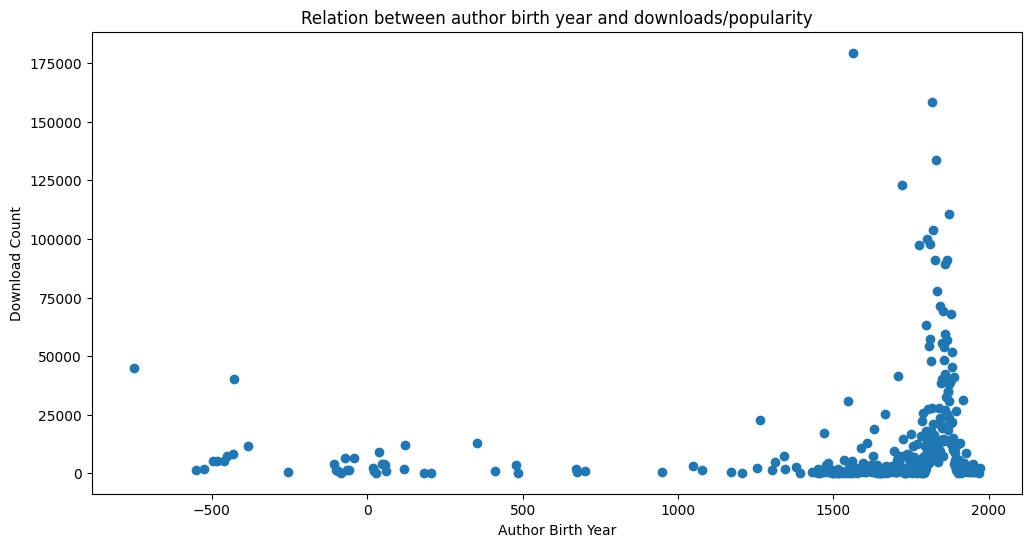

In [128]:
plt.figure(figsize=(12, 6))
plt.scatter(birth_vs_downloads['author_birth_year'], birth_vs_downloads['download_count'])
plt.xlabel('Author Birth Year')
plt.ylabel('Download Count')
plt.title('Relation between author birth year and downloads/popularity')
plt.xticks()
plt.show()

As we can see, the most downloaded books are from the 17th, 18th and 19th century. We can therefore conclude that the Project Gutenberg has a vital role of exposing old literature to this new digital world, bringing people the the views and sentiments of the past generations, across multiple centuries.

# Most popular Authors

First, we create a first_author column in our dataframe. Then we get the name, depending if the book has multiple or just one author. <br>
We proceed to create a new dataframe grouping by the first_author and then aggregating with the downloading count, summing all of them. <br>
We use the reset_index() function to having normal numeric index instead of the author's name.

In [167]:
df_books['first_author'] = df_books['authors'].apply(lambda x: x[0]['name'] if isinstance(x, list) and len(x) > 0 else 'Unknown')

author_download_counts = df_books.groupby('first_author').agg({'download_count': 'sum'}).reset_index()
author_download_counts.columns = ['Author', 'Total Downloads']
author_download_counts = author_download_counts[author_download_counts['Author'] != 'Various']
author_download_counts = author_download_counts.sort_values('Total Downloads', ascending=False)[1:11]

In [168]:
author_download_counts.sample(2)

,Author,Total Downloads
619,"Dickens, Charles",86561
1463,"Melville, Herman",81726


<BarContainer object of 10 artists>

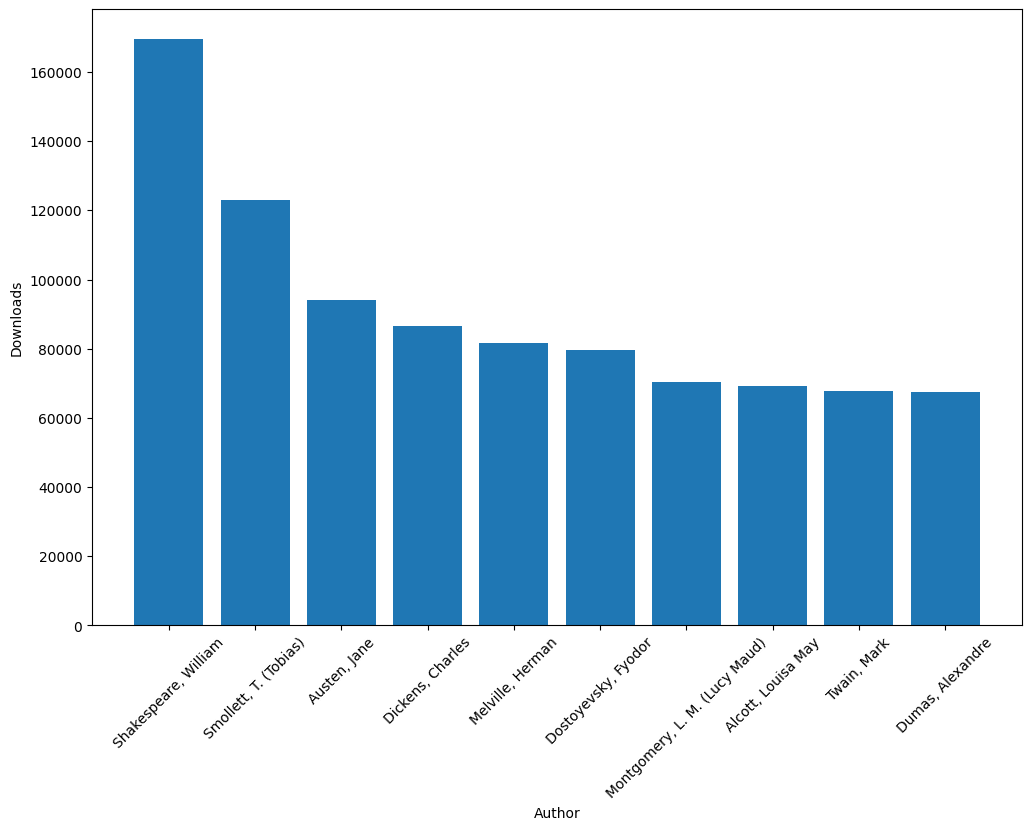

In [169]:
plt.figure(figsize=(12, 8))
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.xlabel('Author')
plt.ylabel('Downloads')

plt.bar(author_download_counts['Author'], author_download_counts['Total Downloads'])

Indeed, an author from the 17th century has the most downloads in books published combined. It matches with the last analysis we did.

<hr>

# Using pandasai LLM

In [145]:
import os
from dotenv import load_dotenv
from pandasai import SmartDataframe

In [146]:
load_dotenv()

True

In [184]:
sdf = SmartDataframe(author_download_counts)

Make a rank based on downloads of british authors.

'e:/projects/ipsense/exports/charts/temp_chart.png'

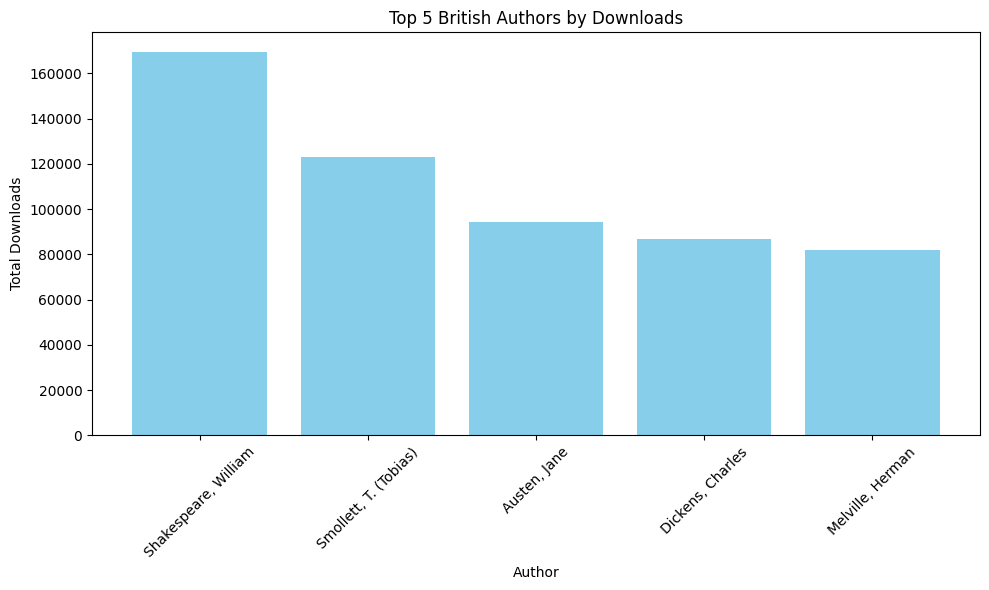

In [175]:
sdf.chat("Plot a top 5 rank with only british authors by downloads")

Make a rank based on downloads of Russian authors.

'e:/projects/ipsense/exports/charts/temp_chart.png'

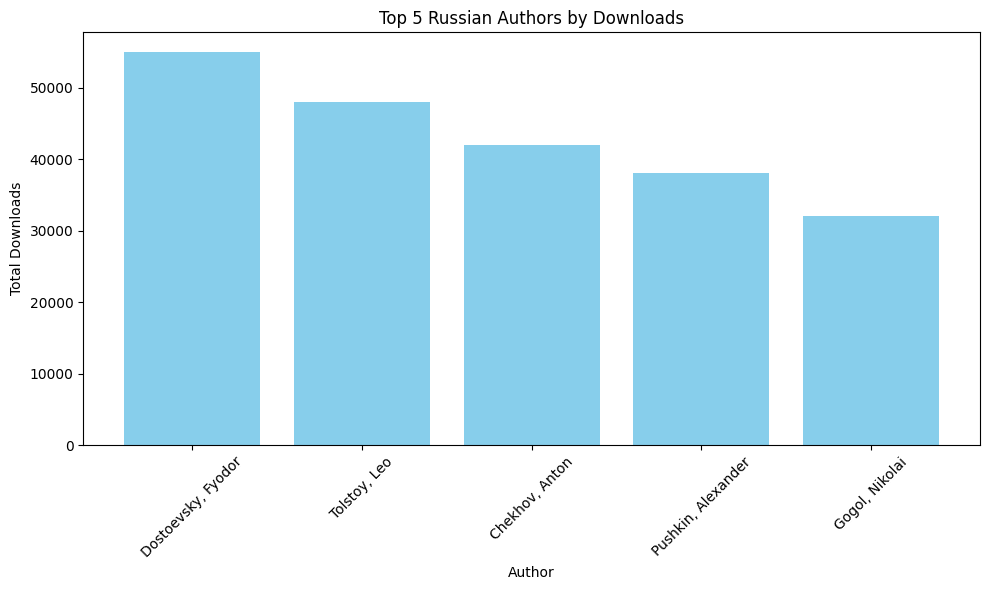

In [176]:
sdf.chat("Plot a top 5 rank with only Russian authors by downloads")

Based on author's birth years, lets find out which century has the most downloaded books, and see a graph with the top 5 centuries by downloads.

In [160]:
sdf = SmartDataframe(birth_vs_downloads)
sdf.chat("Which century has the most downloaded books?")

1900.0

'e:/projects/ipsense/exports/charts/temp_chart.png'

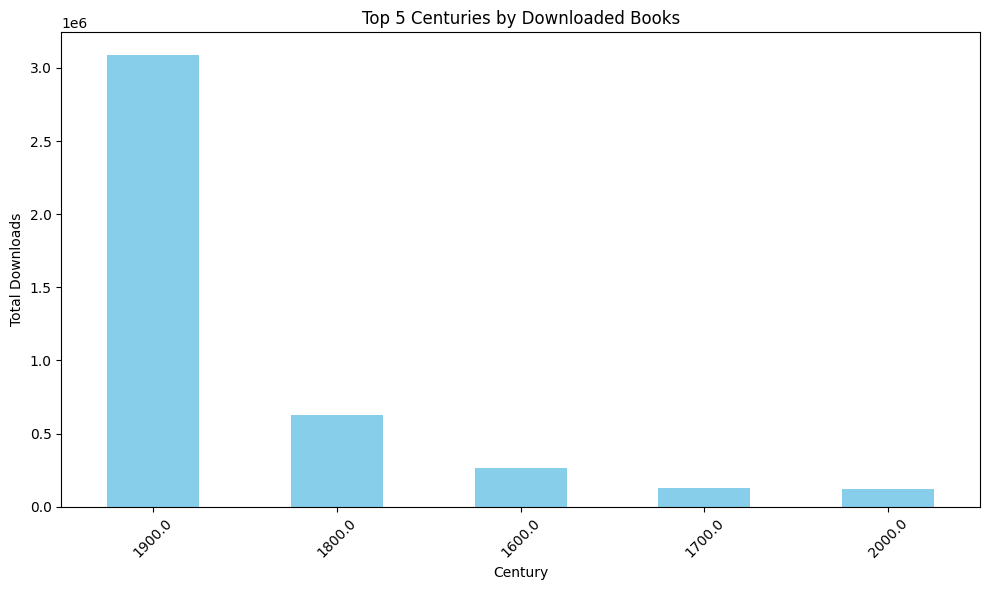

In [138]:
sdf.chat("Plot me a top 5 Centuries by downloaded books")

As we can see, the 19th century has the most popular books. Maybe it has to do with the 2nd industrial revolution, where books were vastly spreaded around the globe. <br>
So the previous generations, from the 19th century, may had an influence to the newer generation, talking about these books, sharing their experiences. This might be <br>
the reason why in the Project Gutemberg, those books have the most downloads overall.

# Final thoughts

Due to some librarie dependencies and configuration I had a rough time setting up this LLM. Althought I've managed to extract the data I intended to, <br>
this model does not have (or I don't know how to fine tune it) a satisfactory results. The results seems random and sometimes not reliable.

But in the end I am very happy that I've managed to analyze this dataframe using the LLM.